# ElCom - Strompreise nach Netzbetreiber und Gemeinde
Contact: [Johannes Hool, Fach- und Koordinationsstelle OGD Basel-Landschaft](mailto:johannes.hool@bl.ch)

# Setup

In [1]:
import numpy as np

import sparql_dataframe

import matplotlib.pyplot as plt
import seaborn as sns


# Load Data

Specify a SPARQL query and download data from LINDAS.

The following fields will be downloaded:

| Column | Description |
| --- | --- |
| period | Year of observation |
| municipality_id | Swiss official commune register ([BFS-Nummer](https://www.bfs.admin.ch/bfs/en/home/basics/swiss-official-commune-register.html)) |
| municipality_name | Name of the municipality |
| operator_identifier | UID of the operator (see [UID-Register](https://www.uid.admin.ch/Pages/search.aspx?lang=en)) |
| operator_name | Name of the operator |
| product_name | Type of the product. In this case this is always "Standardprodukt". If the above query is adapted there is also a sporadic "Günstigstes Produkt" |
| category_name | Consumption Category (i.e. [Verbrauchskategorie](https://www.elcom.admin.ch/dam/elcom/de/dokumente/2022/wegleitungzurtarifdeklaration2022fuertarife2023.pdf.download.pdf/Wegleitung%20zur%20Tarifdeklaration%202022%20f%C3%BCr%20Tarife%202023%20DE.pdf)). This category is the decisive factor for the fix and variable costs per kWh |
| category_description | A free text description of the consumption category |
| grid | Grid fee in Rp. per kWh (Price for transporting electricity from the power plant to the home) |
| energy | Electricity fee in Rp. per kWh (Price of the electrical energy supplied) |
| community_fee | Taxes and fees from the municipality and the canton in Rp. per kWh |
| aidfee | Federal tax for the promotion of renewable energies in Rp. per kWh |
| fix_costs | Monthly fix costs for the access |
| variable_costs | Cost per kWh in Rp. This is the sum of grid + energy + community_fee + aidfee |

In [2]:
canton = 'BL' # Specify for which canton the data should be downloaded

endpoint = 'https://lindas.admin.ch/query' # Query the LINDAS data

query = ''' # Query to get energy prices per period, municipality and operator for the canton Basel-Landschaft
PREFIX cube: <https://cube.link/>
PREFIX schema: <http://schema.org/>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>

PREFIX strom: <https://energy.ld.admin.ch/elcom/electricityprice/dimension/>

SELECT ?period ?municipality_id ?municipality_name ?operator_identifier ?operator_name
        ?product_name ?category_name ?category_description ?grid ?aidfee ?community_fee
        ?energy ?fix_costs ?variable_costs

FROM <https://lindas.admin.ch/elcom/electricityprice>                                       # Query elcom data for electricity prices
FROM <https://lindas.admin.ch/fso/register>                                                 # Query fso register data to 

WHERE
{

  <https://energy.ld.admin.ch/elcom/electricityprice> a cube:Cube ;                         # Query all cubes in elcom data
  	cube:observationSet/cube:observation ?obs.
  
  ?obs strom:period ?period;                                                                # i.e. year
    strom:municipality ?municipality;
    strom:operator ?operator;
    strom:category ?category;                                                               # Consumption category of household / company
    strom:product ?product;                                                                 # Product (i.e. standard plan or cheapest plan)
    strom:gridusage ?grid;                                                                  # Price for grid usage per kWh
    strom:energy ?energy;                                                                   # Price for electricity per kWh
    strom:charge ?community_fee;                                                            # Community tax per kWh
    strom:aidfee ?aidfee;                                                                   # Federal tax per kWh
    strom:total ?variable_costs;                                                            # Sum of all the variable costs (per kWh) above
    strom:fixcosts ?fix_costs.                                                              # Monthly fix costs
    
  ?product schema:name ?product_name.                                                       # Name of the product
  
  ?category schema:name ?category_name;                                                     # Name of the consumption category
    schema:description ?category_description.                                               # Description of the consumption category
  
  ?operator schema:identifier ?operator_identifier;                                         # Id of operator
    schema:name ?operator_name.                                                             # Name of operator


  ?canton a <https://schema.ld.admin.ch/Canton>;                                            # Cantons and short canton name from fso register (only used for filtering)
   schema:alternateName ?canton_abbr.

  ?municipality schema:name ?municipality_name;                                             # Municipality name                                   
    schema:identifier ?municipality_id.                                                     # Id of Municipality
  
  # Filtering section     

  ?municipality schema:containedInPlace ?canton.                                            # Only use municipalities which belong to the below selected canton (used for filtering)
  ?obs strom:product <https://energy.ld.admin.ch/elcom/electricityprice/product/standard>.  # Only use standard product (there is also sometimes an alternative cheapest product)
  
  FILTER (?canton_abbr = '%s')                                                              # Only use the canton X and therefore also only municipalities from this canton 
  FILTER (LANG(?product_name) = 'de').                                                      # Only use the cerman product name
  FILTER (?period > '2017'^^xsd:gYear).                                                     # Only use data starting 2018. Before 2018 the standard product was sometimes the cheapest product. Starting 2018 the most eco friendly pricing model became the standard product. When comparing prices between years, older data can therefore result in misinterpretations
}
''' % (canton)

df = sparql_dataframe.get(endpoint, query) # Run query

# Transform Data

- Split up information from descriptive columns into multiple columns
- Calculate monthly bill based on typical yearly consumption, fix and variable prices

The following fields will be added to the data frame:

| Column | Description |
| --- | --- |
| consumption | Typical consumption per year of a household/company in this category (in kWh). Extracted from the free text description of the consumption category.|
| category_description_short | Shortened free text description of the consumption category |
| monthly_bill | Typical monthly bill (in Chf) of a household/company in this category. This is calculated using the typical consumption, the fixed and variable costs |

In [3]:
def consumption_from_description(desc: str) -> int:
    '''
    This function is used to get the consumption as integer from the category description.

    E.g. 1'600 kWh/Jahr, 2-Zimmerwohnung mit Elektroherd -> 1600

    '''

    number = desc.split('kWh/Jahr')[0] # Each description starts with the consumption in kWh. We use this to split the string
    number = number.replace(' ', '').replace("'", "") # Remove apostrophes and leading empty characters

    return int(number) # Return number


def shortened_description(desc: str) -> int:
    '''
    This function is used to get the shortened description by removing the typical energy consumption

    '''

    desc = desc.split('kWh/Jahr')[1][2:] # Each description starts with the typical consumption in kWh. We use this to split the string and remove the leading ": " from the description
    desc = desc.replace("'", '') # Remove apostrophes
    desc = ' '.join(desc.split()) # Trim leading space characters
    return desc # Return shortened description

df['consumption'] = df['category_description'].apply(consumption_from_description) # Create column with numeric consumption of the corresponding categorie
df['category_description_short'] = df['category_description'].apply(shortened_description) # Create column with numeric consumption of the corresponding categorie
df['monthly_bill'] = ((df['variable_costs']*df['consumption']/12 + df['fix_costs'])/100).round(2) # Create column with the monthly costs based on the consumption and the fixed and variable costs


# Validate Data

- Look at data
- Check if or all municipalities there is the same number of observations
- Check if there are outliers
- Look at municipalities with multiple operators
- Plot some data

In [4]:
df.head()

,period,municipality_id,municipality_name,operator_identifier,operator_name,product_name,category_name,category_description,grid,aidfee,community_fee,energy,fix_costs,variable_costs,consumption,category_description_short,monthly_bill
0,2020,2827,Hersberg,CHE-105.966.413,Elektra Baselland,Standardprodukt,H1,1'600 kWh/Jahr: 2-Zimmerwohnung mit Elektroherd,14.527187,2.3,0.34,10.128125,46.8,27.295313,1600,2-Zimmerwohnung mit Elektroherd,36.86
1,2020,2833,Seltisberg,CHE-105.966.413,Elektra Baselland,Standardprodukt,H1,1'600 kWh/Jahr: 2-Zimmerwohnung mit Elektroherd,14.527187,2.3,0.34,10.128125,46.8,27.295313,1600,2-Zimmerwohnung mit Elektroherd,36.86
2,2020,2853,Maisprach,CHE-105.966.413,Elektra Baselland,Standardprodukt,H1,1'600 kWh/Jahr: 2-Zimmerwohnung mit Elektroherd,14.527187,2.3,0.00,10.128125,46.8,26.955313,1600,2-Zimmerwohnung mit Elektroherd,36.41
3,2020,2884,Diegten,CHE-105.966.413,Elektra Baselland,Standardprodukt,H1,1'600 kWh/Jahr: 2-Zimmerwohnung mit Elektroherd,14.527187,2.3,0.34,10.128125,46.8,27.295313,1600,2-Zimmerwohnung mit Elektroherd,36.86
4,2020,2841,Anwil,CHE-105.966.413,Elektra Baselland,Standardprodukt,H1,1'600 kWh/Jahr: 2-Zimmerwohnung mit Elektroherd,14.527187,2.3,0.34,10.128125,46.8,27.295313,1600,2-Zimmerwohnung mit Elektroherd,36.86


In [5]:
# Number of municipalities by year
df.groupby('period')['municipality_id'].nunique()

period
2018    86
2019    86
2020    86
2021    86
2022    86
2023    86
2024    86
Name: municipality_id, dtype: int64

In [6]:
# Number of Operators per municipality
df_multiple_operators = df.groupby(['period', 'municipality_name'])['operator_name'].nunique().sort_values(ascending=False).reset_index()
df_multiple_operators

,period,municipality_name,operator_name
0,2020,Pratteln,2
1,2024,Pratteln,2
2,2023,Itingen,2
3,2019,Laufen,2
4,2019,Reigoldswil,2
...,...,...,...
597,2020,Känerkinden,1
598,2020,Lampenberg,1
599,2020,Langenbruck,1
600,2020,Lausen,1


In [7]:
# Print out outliers

std_range = 3 # This parameter defines, how many standard deviations from the mean should be used to calculate the interval for "normal" observations

for category in df.sort_values('category_name')['category_name'].unique(): # Iterate over all categories

    # Calculate min and max of the interval for this category
    standard_deviation = np.std(df[df['category_name'] == category]['monthly_bill'])
    mean = np.mean(df[df['category_name'] == category]['monthly_bill'])
    min_val = mean - std_range*standard_deviation
    max_val = mean + std_range*standard_deviation

    # Print outliers
    print(f'{category}: Entries <> {std_range} standard deviations from the mean for monthly_bill ({min_val} - {max_val})')
    print()

    df_vis = df[(df['category_name'] == category) & ((df['monthly_bill'] > max_val) | (df['monthly_bill'] < min_val))]
    print(df_vis[['municipality_name', 'operator_name', 'period', 'monthly_bill']].sort_values(['municipality_name', 'operator_name', 'period']))
    print()
    print('------------------------------')

C1: Entries <> 3 standard deviations from the mean for monthly_bill (68.20949952940764 - 248.68079504423577)

Empty DataFrame
Columns: [municipality_name, operator_name, period, monthly_bill]
Index: []

------------------------------
C2: Entries <> 3 standard deviations from the mean for monthly_bill (220.43331258900196 - 897.1738191939438)

Empty DataFrame
Columns: [municipality_name, operator_name, period, monthly_bill]
Index: []

------------------------------
C3: Entries <> 3 standard deviations from the mean for monthly_bill (1036.5519157069057 - 4060.067218759864)

     municipality_name                       operator_name  period  \
3156       Reigoldswil  Elektra Reigoldswil Genossenschaft    2024   

      monthly_bill  
3156       4593.92  

------------------------------
C4: Entries <> 3 standard deviations from the mean for monthly_bill (1957.4765604224349 - 13290.509327428033)

     municipality_name                      operator_name  period  \
3609             Augst     

For Basel-Landschaft it appears that for C4, C5, C6 and C7 there exist entries where the monthly bill would be 0 CHF which is not plausible. A comparison of the prices listed by Elektra Itingen shows that for the years in question no such category was available. (e.g. [2023](https://www.elektra-itingen.ch/hubfs/ELI/pdf/Tarife/2023/Preisblatt_G23_Industrie.pdf) and [2024](https://www.elektra-itingen.ch/hubfs/ELI_Preisblatt_G24_Industrie.pdf?hsLang=de)). We assume that for other operators whith a monthly bill of 0 CHF this is also the case.

We therefore remove all entries where the monthly bill is 0 CHF because those entries should be missing instead of containing wrong price data.

**Note:** During our research, the ElCom confirmed to us that missing offers are sometimes erroneously marked with the number 0 by the network operators. However, the responsibility for the correctness of the data lies with the network operators, which is why ElCom cannot make any corrections. Therefore, the validity of the data will always have to be verified in future analyses and exports.

In [8]:
# Print entries that will be removed after cleansing

print('The following entries are removed')
df[df['monthly_bill'] == 0][['municipality_name', 'operator_name', 'category_name', 'period']].sort_values(['municipality_name', 'operator_name', 'category_name', 'period'])

The following entries are removed


,municipality_name,operator_name,category_name,period
3609,Augst,Elektra Augst,C4,2018
3332,Augst,Elektra Augst,C4,2019
3339,Augst,Elektra Augst,C4,2020
3575,Augst,Elektra Augst,C4,2021
3585,Augst,Elektra Augst,C5,2018
3550,Augst,Elektra Augst,C5,2019
3549,Augst,Elektra Augst,C5,2020
3554,Augst,Elektra Augst,C5,2021
3584,Augst,Elektra Augst,C6,2018
3562,Augst,Elektra Augst,C6,2019


In [9]:
print('Rows before cleansing:', len(df))

df = df[df['monthly_bill'] != 0] # Remove erronous entries

print('Rows after cleansing:', len(df))

Rows before cleansing: 9670
Rows after cleansing: 9629


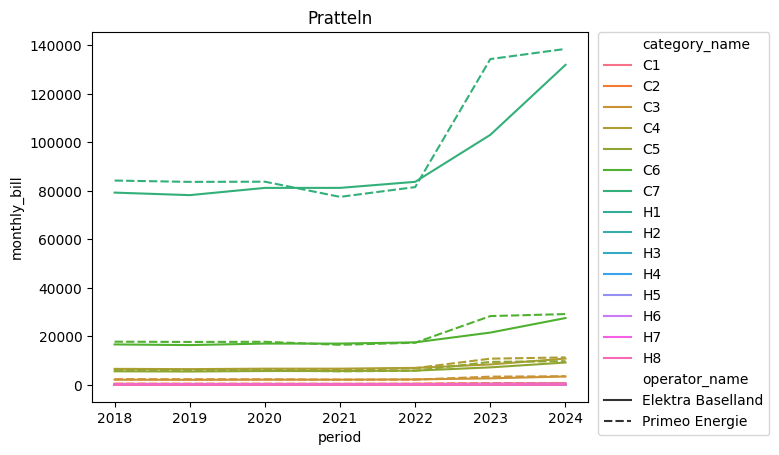

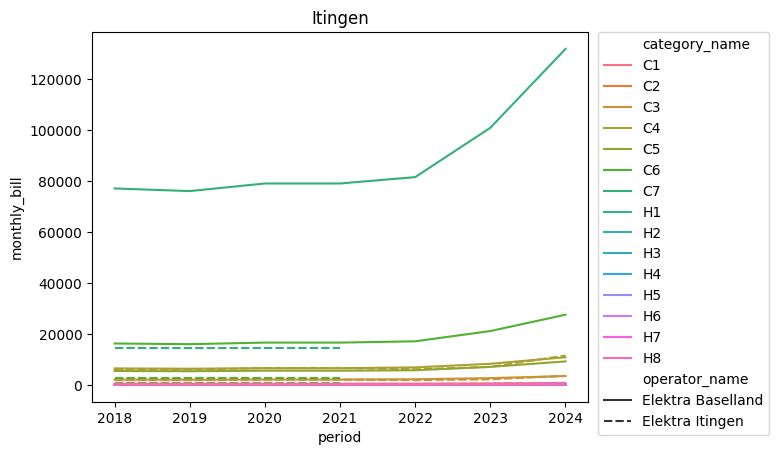

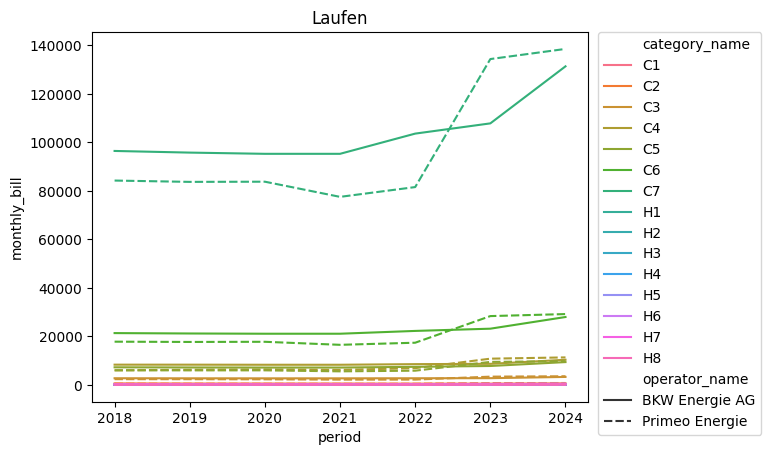

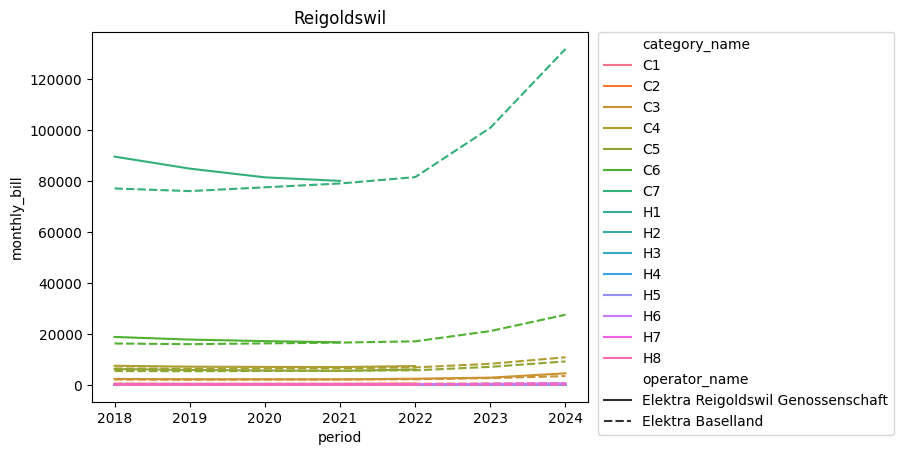

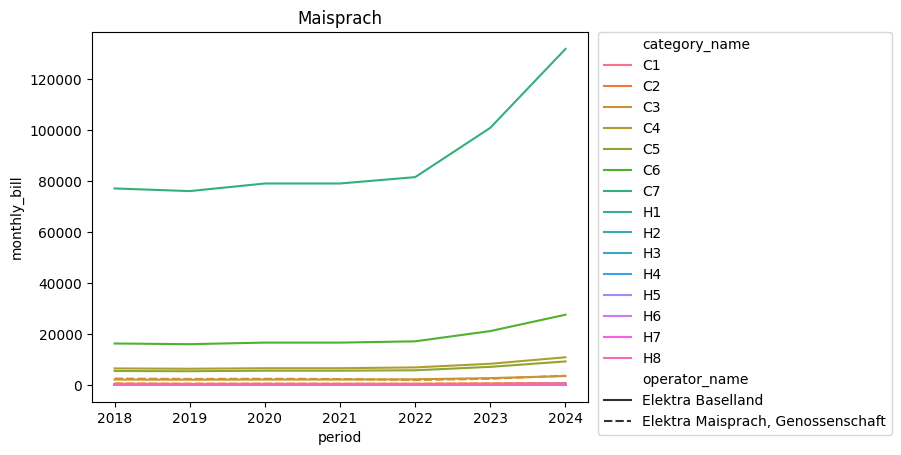

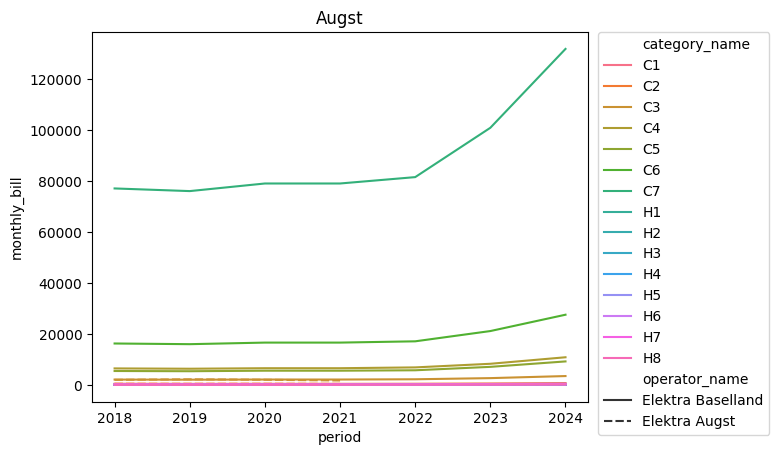

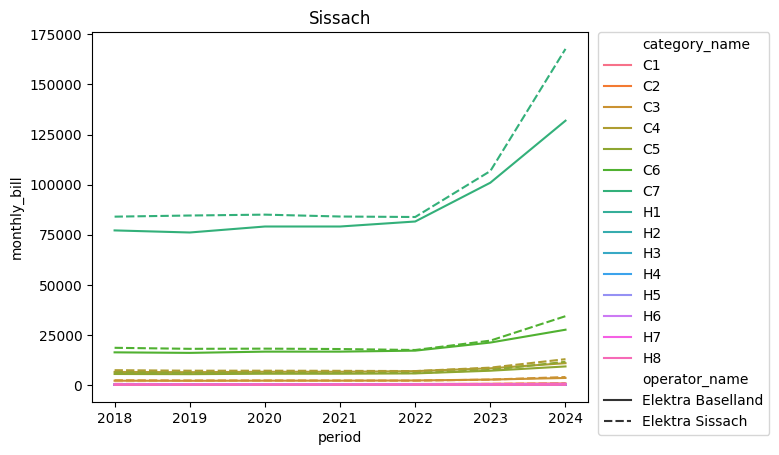

In [10]:
# Plot changes in monthly bills over time for municipalities with multiple operators

for municipality_name in df_multiple_operators[df_multiple_operators['operator_name'] > 1]['municipality_name'].unique():
# for municipality_name in df['municipality_name'].unique():    # Uncomment this line to plot all municipalities
    df_vis = df[df['municipality_name'] == municipality_name].sort_values('category_name')
    plt.figure()
    sns.lineplot(data=df_vis, x='period', y='monthly_bill', hue='category_name', style='operator_name').set(title=municipality_name)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

The prices for the municipalities with multiple operators seem plausible

# Aggregate and Write Data
- Select and rename columns
- Write data to csv file

The final data set will have the following columns:

The following fields will be downloaded:

| Column | Description |
| --- | --- |
| Jahr | Year of observation |
| BFS_Gemeindenummer | Swiss official commune register ([BFS-Nummer](https://www.bfs.admin.ch/bfs/en/home/basics/swiss-official-commune-register.html)) |
| Gemeinde | Name of the municipality |
| UID_Verteilnetzbetreiber | UID of the operator (see [UID-Register](https://www.uid.admin.ch/Pages/search.aspx?lang=en)) |
| Verteilnetzbetreiber | Name of the operator |
| Produkt | Type of the product. In this case this is always "Standardprodukt". If the above query is adapted there is also a sporadic "Günstigstes Produkt" |
| Verbrauchskategorie | Consumption Category (i.e. [Verbrauchskategorie](https://www.elcom.admin.ch/dam/elcom/de/dokumente/2022/wegleitungzurtarifdeklaration2022fuertarife2023.pdf.download.pdf/Wegleitung%20zur%20Tarifdeklaration%202022%20f%C3%BCr%20Tarife%202023%20DE.pdf)). This category is the decisive factor for the fix and variable costs per kWh |
| Verbrauchskategorie_Beschreibung | A free text description of the consumption category |
| Variable_Kosten_Rp_pro_kWh | Cost per kWh in Rp. This is the sum of grid + energy + community_fee + aidfee |
| Fixe_Kosten_Rp_pro_Monat | Monthly fix costs for the access |
| Typischer_Verbrauch_kWh_pro_Jahr | Typical consumption per year of a household/company in this category (in kWh). Extracted from the free text description of the consumption category.|
| Kosten_typischer_Verbrauch_Chf_pro_Monat | Typical monthly bill (in Chf) of a household/company in this category. This is calculated using the typical consumption, the fixed and variable costs |
| Kosten_Vorjahr_typischer_Verbrauch_Chf_pro_Monat | Typical monthly bill (in Chf) from the year before |



In [11]:
# Sort Dataframe
df = df.sort_values(['municipality_id', 'operator_identifier', 'period', 'category_name'], ascending=[True, True, False, True]) # Sort values by period (year) in ascending order

# Select columns to write
df = df[['municipality_id', 'municipality_name', 'period', 'operator_identifier', 'operator_name', 'product_name', 'category_name', 'category_description_short', 'consumption', 'variable_costs', 'fix_costs', 'monthly_bill']]

# Rename columns
df.columns = ['BFS_Gemeindenummer', 'Gemeinde', 'Jahr', 'UID_Verteilnetzbetreiber',
       'Verteilnetzbetreiber', 'Produkt', 'Verbrauchskategorie',
       'Verbrauchskategorie_Beschreibung', 'Typischer_Verbrauch_kWh_pro_Jahr', 
       'Variable_Kosten_Rp_pro_kWh', 'Fixe_Kosten_Rp_pro_Monat', 'Kosten_typischer_Verbrauch_CHF_pro_Monat']

# ATTENTION
# This git repository does not sync data folders. Upon first execution, a data folder has to be created where the file can be written to
df.to_csv('data/basisdaten_verteilnetzbetreiber.csv', sep=';', index=False)

df

,BFS_Gemeindenummer,Gemeinde,Jahr,UID_Verteilnetzbetreiber,Verteilnetzbetreiber,Produkt,Verbrauchskategorie,Verbrauchskategorie_Beschreibung,Typischer_Verbrauch_kWh_pro_Jahr,Variable_Kosten_Rp_pro_kWh,Fixe_Kosten_Rp_pro_Monat,Kosten_typischer_Verbrauch_CHF_pro_Monat
5313,2761,Aesch (BL),2024,CHE-109.319.939,Primeo Energie,Standardprodukt,C1,Kleinstbetrieb max. beanspruchte Leistung: 8 kW,8000,33.886803,0.0,225.91
6811,2761,Aesch (BL),2024,CHE-109.319.939,Primeo Energie,Standardprodukt,C2,Kleinbetrieb max. beanspruchte Leistung: 15 kW,30000,32.866962,0.0,821.67
5285,2761,Aesch (BL),2024,CHE-109.319.939,Primeo Energie,Standardprodukt,C3,Mittlerer Betrieb max. beanspruchte Leistung: ...,150000,28.829210,0.0,3603.65
5523,2761,Aesch (BL),2024,CHE-109.319.939,Primeo Energie,Standardprodukt,C4,Grosser Betrieb max. beanspruchte Leistung: 15...,500000,27.299627,0.0,11374.84
8816,2761,Aesch (BL),2024,CHE-109.319.939,Primeo Energie,Standardprodukt,C5,Grosser Betrieb max. beanspruchte Leistung: 15...,500000,23.555511,0.0,9814.80
...,...,...,...,...,...,...,...,...,...,...,...,...
8168,2895,Waldenburg,2018,CHE-105.966.413,Elektra Baselland,Standardprodukt,H4,5-Zimmerwohnung mit Elektroherd und Tumbler (o...,4500,20.928572,46.8,78.95
1389,2895,Waldenburg,2018,CHE-105.966.413,Elektra Baselland,Standardprodukt,H5,5-Zimmer-Einfamilienhaus mit Elektroherd Elekt...,7500,18.166857,46.8,114.01
2772,2895,Waldenburg,2018,CHE-105.966.413,Elektra Baselland,Standardprodukt,H6,5-Zimmer-Einfamilienhaus mit Elektroherd Elekt...,25000,15.222057,46.8,317.59
4450,2895,Waldenburg,2018,CHE-105.966.413,Elektra Baselland,Standardprodukt,H7,5-Zimmer-Einfamilienhaus mit Elektroherd Elekt...,13000,17.361813,46.8,188.55
